## MSDS458 Research Assignment 02 Experiments

Experiment 1: DNN with 2 layers (no regularization)

Experiment 2: DNN with 3 layers (no regularization)

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Experiment 5+ : You will conduct several more experiments. 
(a) Redo all the 4 experiments with some regularization technique. 
(b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab Environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Functions for Research Assignment

In [6]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [9]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [13]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

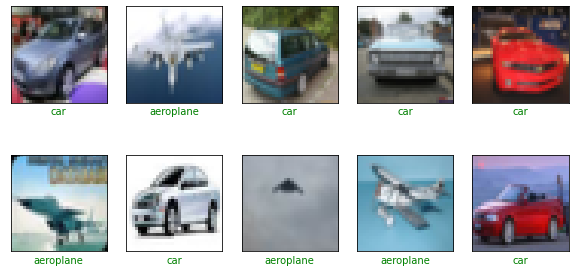

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [18]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


In [ ]:
"""
#Build CNN Model
#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))
"""

In [19]:
def compile_train_plot_model(model):
  #plot model
  keras.utils.plot_model(model1, "CIFAR10.png", show_shapes=True) 

  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=20
                      ,batch_size=100
                      ,validation_data=(x_valid_norm, y_valid_split)
                      ,callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                      tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  #plot performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)
  history_df.tail().round(3)

  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  #loss and accuracy for training and validation data
  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
  plt.show()                        

  #confuison matrix
  pred1= model.predict(x_test_norm)
  pred1=np.argmax(pred1, axis=1)
  print_validation_report(y_test, pred1)
  plot_confusion_matrix(y_test,pred1)


### Experiment 1: DNN with 2 layers (no regularization)

In [20]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1.add(layers.Flatten(name ='flatten'))
model1.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model1.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 3s 4ms/step - loss: 1.9650 - accuracy: 0.3130 - val_loss: 1.7999 - val_accuracy: 0.3638
Epoch 2/20
450/450 [==============================] - 2s 4ms/step - loss: 1.7426 - accuracy: 0.3830 - val_loss: 1.7012 - val_accuracy: 0.3916
Epoch 3/20
450/450 [==============================] - 2s 4ms/step - loss: 1.6714 - accuracy: 0.4089 - val_loss: 1.6533 - val_accuracy: 0.4194
Epoch 4/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6160 - accuracy: 0.4291 - val_loss: 1.6450 - val_accuracy: 0.4068
Epoch 5/20
450/450 [==============================] - 2s 4ms/step - loss: 1.5805 - accuracy: 0.4418 - val_loss: 1.6113 - val_accuracy: 0.4266
Epoch 6/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5448 - accuracy: 0.4554 - val_loss: 1.5869 - val_accuracy: 0.4290
Epoch 7/20
450/450 [==============================] - 3s 7ms/step - loss: 1.5199 - accuracy: 0.4630 - val_loss: 1.5565 - val_accuracy: 0.4498
Epoch 

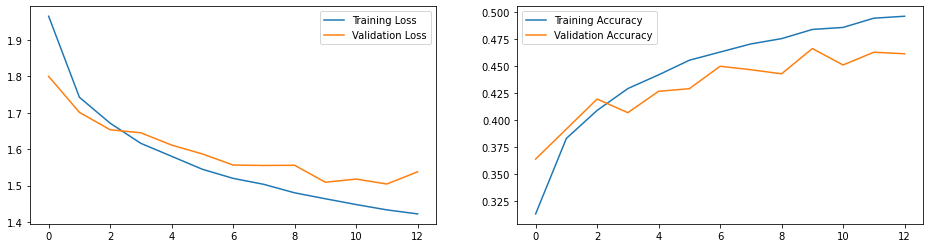

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.31      0.44      1000
           1       0.54      0.53      0.54      1000
           2       0.35      0.39      0.37      1000
           3       0.34      0.33      0.34      1000
           4       0.44      0.37      0.40      1000
           5       0.44      0.28      0.34      1000
           6       0.48      0.57      0.52      1000
           7       0.54      0.54      0.54      1000
           8       0.57      0.64      0.60      1000
           9       0.40      0.70      0.51      1000

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.46     10000
weighted avg       0.48      0.47      0.46     10000

Accuracy Score: 0.4659
Root Mean Square Error: 3.31463421813026


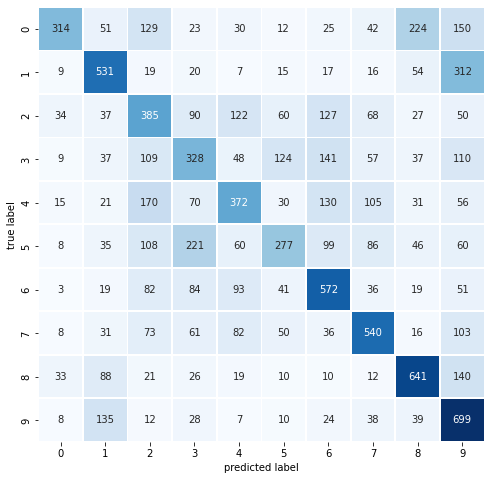

In [21]:
compile_train_plot_model(model1)

In [22]:
history_df.head(5)

NameError: ignored

## Experiment 2: DNN with 3 layers (no regularization)

In [23]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2.add(layers.Flatten(name ='flatten'))
model2.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 hidden_layer2 (Dense)       (None, 384)               147840    
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,331,722
Trainable params: 1,331,722
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8834 - accuracy: 0.3226 - val_loss: 1.7595 - val_accuracy: 0.3630
Epoch 2/20
450/450 [==============================] - 1s 3ms/step - loss: 1.6813 - accuracy: 0.3975 - val_loss: 1.7033 - val_accuracy: 0.3962
Epoch 3/20
450/450 [==============================] - 1s 3ms/step - loss: 1.5951 - accuracy: 0.4314 - val_loss: 1.6065 - val_accuracy: 0.4240
Epoch 4/20
450/450 [==============================] - 1s 3ms/step - loss: 1.5423 - accuracy: 0.4518 - val_loss: 1.5525 - val_accuracy: 0.4450
Epoch 5/20
450/450 [==============================] - 2s 4ms/step - loss: 1.4915 - accuracy: 0.4690 - val_loss: 1.5510 - val_accuracy: 0.4492
Epoch 6/20
450/450 [==============================] - 2s 3ms/step - loss: 1.4559 - accuracy: 0.4836 - val_loss: 1.5168 - val_accuracy: 0.4568
Epoch 7/20
450/450 [==============================] - 2s 3ms/step - loss: 1.4230 - accuracy: 0.4950 - val_loss: 1.5004 - val_accuracy: 0.4680
Epoch 

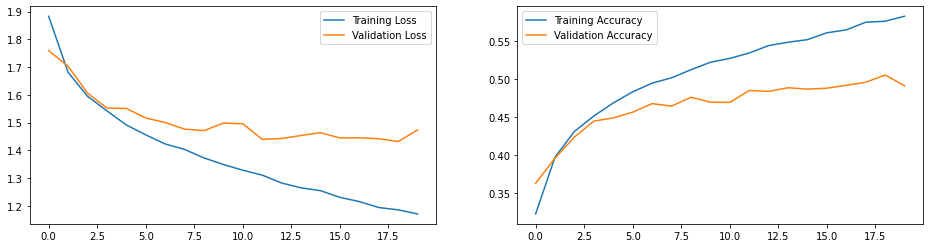

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.76      0.57      1000
           1       0.64      0.60      0.62      1000
           2       0.41      0.40      0.40      1000
           3       0.34      0.35      0.35      1000
           4       0.42      0.48      0.45      1000
           5       0.47      0.36      0.41      1000
           6       0.51      0.59      0.55      1000
           7       0.60      0.55      0.57      1000
           8       0.73      0.52      0.60      1000
           9       0.63      0.46      0.53      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.51     10000
weighted avg       0.52      0.51      0.51     10000

Accuracy Score: 0.5063
Root Mean Square Error: 3.122290825659903


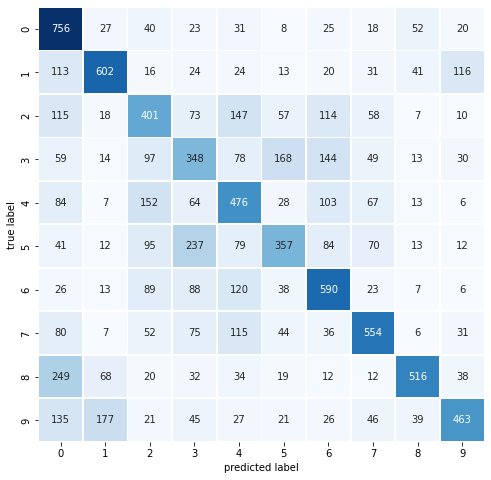

In [24]:
compile_train_plot_model(model2)

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.8072.h5')

In [ ]:
preds = model.predict(x_test_norm)

In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.13%,0.35%,1.23%,86.03%,0.30%,7.76%,2.37%,0.12%,1.40%,0.32%
1,0.99%,17.22%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,81.39%,0.39%
2,1.08%,8.46%,0.04%,0.10%,0.00%,0.01%,0.02%,0.00%,71.48%,18.80%
3,94.92%,0.40%,0.02%,0.07%,0.01%,0.00%,0.00%,0.01%,4.40%,0.16%
4,0.00%,0.00%,0.26%,0.60%,28.51%,0.02%,70.60%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.01%,0.12%,0.01%,0.40%,99.45%,0.00%,0.00%,0.00%
6,0.00%,94.00%,0.00%,0.02%,0.00%,0.01%,0.00%,0.00%,0.00%,5.96%
7,0.02%,0.00%,11.40%,4.89%,15.76%,0.28%,67.60%,0.02%,0.01%,0.03%
8,0.00%,0.00%,0.32%,85.83%,6.73%,5.58%,1.43%,0.12%,0.00%,0.00%
9,0.01%,3.43%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%,0.02%,96.52%


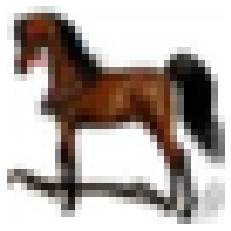

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_3',
 'max_pooling2d_3',
 'dropout_3',
 'conv2d_4',
 'max_pooling2d_4',
 'dropout_4',
 'conv2d_5',
 'max_pooling2d_5',
 'dropout_5',
 'flatten_1',
 'batch_normalization_1',
 'dense_2',
 'dense_3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


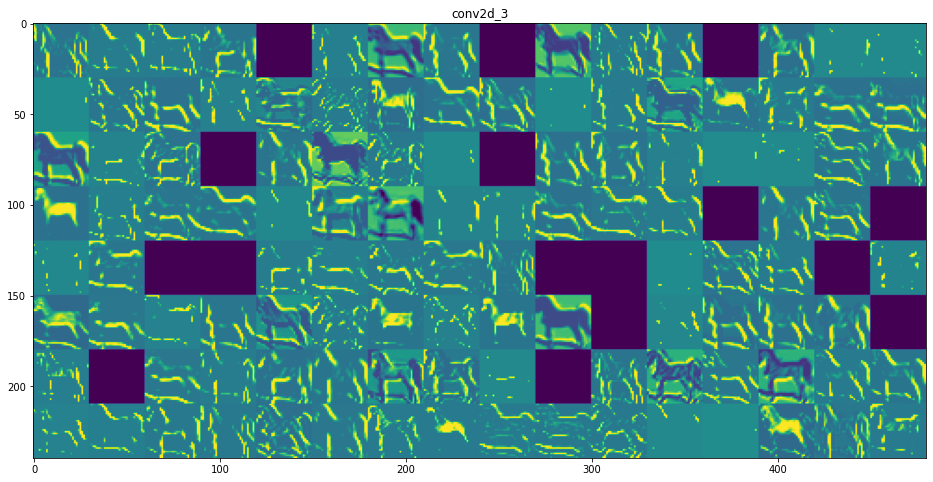

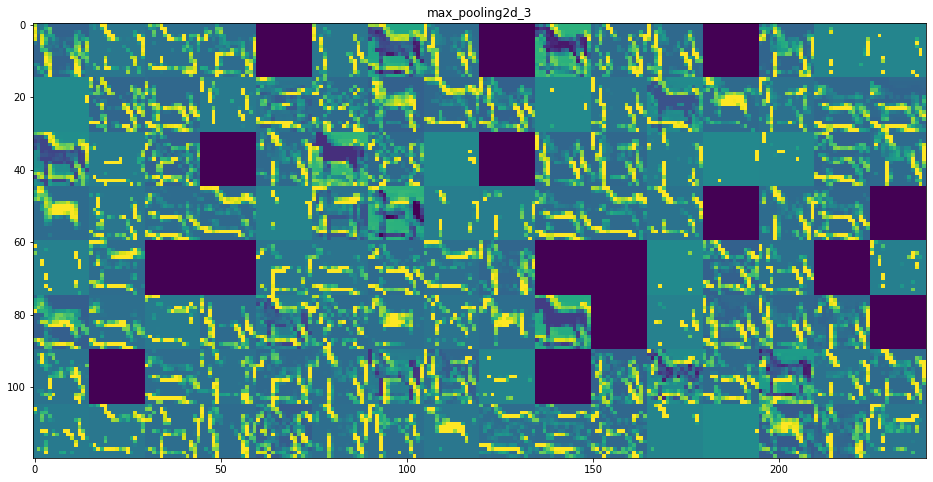

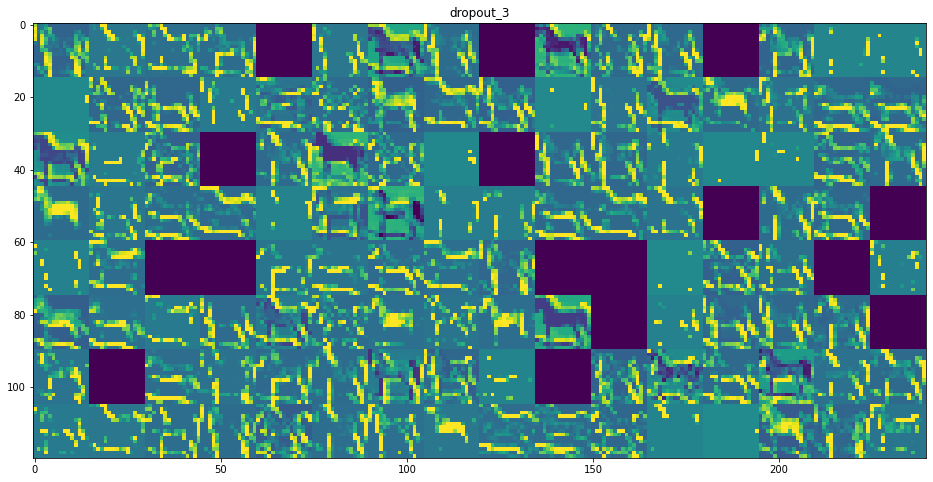

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();